In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
from datetime import datetime as date
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split


# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

# Check that everything worked.  In this EDA, there should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 13 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28808 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.9+ MB


In [3]:
# Only working with the 94% under 80k.
df = df.loc[df.bond_amount<=80000]
print(df.info())

# Separate out the two datasets, misdemeanor (primary) and felony.
felony_df = df.loc[df['offense_class'].str.endswith('F')]
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

# Divide the misdemeanor data into pre-enactment and post.
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

# Change race, gender, facility, and detainer to category type and verify.
df.race = df.race.astype('category')
df.gender = df.gender.astype('category')
df.facility = df.facility.astype('category')
df.detainer = df.detainer.astype('category')
df.offense_class = df.offense_class.astype('category')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21175 entries, 1 to 28807
Data columns (total 13 columns):
download_date            21175 non-null datetime64[ns]
identifier               21175 non-null object
latest_admission_date    21175 non-null datetime64[ns]
race                     21175 non-null object
gender                   21175 non-null object
age                      21175 non-null int64
bond_amount              21175 non-null int64
offense                  21175 non-null object
facility                 21175 non-null object
detainer                 21175 non-null object
offense_class            21175 non-null object
days                     21175 non-null int64
counts                   21175 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.3+ MB
None


In [4]:
target = pd.DataFrame(mis_pre_df.race)
data = mis_pre_df[['bond_amount','days','age']]
target.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3689 entries, 3 to 28799
Data columns (total 3 columns):
bond_amount    3689 non-null int64
days           3689 non-null int64
age            3689 non-null int64
dtypes: int64(3)
memory usage: 115.3 KB


((3689, 1), None)

# Logistic Regression alone gives better "accuracy," but gives weird errors about the shape of y.  Blocks 7 and 8 have much higher accuracy on first run.

In [5]:
X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# Instantiate the classifier
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy, race: {}".format(clf.score(X_test, y_test)))

Accuracy, race: 0.43450767841011745


There are 386 tokens in Offense if we split on non-alphanumeric
['16 to', '16 to operate', '16 to operate mv', '2nd deg', '2nd degree', '3rd degree', '3rd victim', '3rd victim over', '3rd victim over 59', 'a prostitute', 'allowing person', 'allowing person under', 'allowing person under 16', 'allowing person under 16 to', 'an emergency']


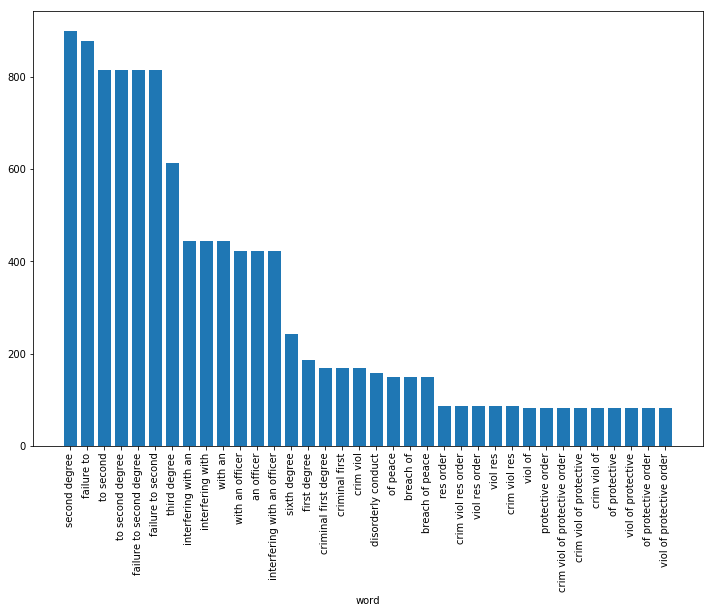

In [6]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,ngram_range=(2, 5))

# Fit to the data
vec_alphanumeric.fit(mis_pre_df.offense)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Offense if we split on non-alphanumeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

# Plot the n-grams by frequency
plot = pd.DataFrame(vec_alphanumeric.fit_transform(mis_pre_df.offense).toarray().sum(axis=0).tolist())
plot['vocab'] = vec_alphanumeric.get_feature_names()
plot.columns = ['freq','vocab']
plot.sort_values(by='freq',ascending=False,inplace=True)

plotted = plot.loc[plot.freq>=80]

_, ax = plt.subplots(figsize=(12,8))
_ = plt.bar(plotted.vocab, plotted.freq)
_ = plt.xlabel('word')
_ = plt.xticks(rotation=90)

In [7]:
target = pd.DataFrame(mis_pre_df.gender)
data = mis_pre_df[['bond_amount','days','age']]

X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# Instantiate the classifier
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy, gender: {}".format(clf.score(X_test, y_test)))

Accuracy, gender: 0.8130081300813008


In [8]:
target = pd.DataFrame(mis_pre_df.offense_class)
data = mis_pre_df[['bond_amount','days','age']]

X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

# Instantiate the classifier
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy, offense class: {}".format(clf.score(X_test, y_test)))

Accuracy, offense class: 0.7326106594399278
